In [1]:
import os
os.environ['PATH'] = "/home/riascodc/DelftOpenSource/bin:" + os.environ['PATH']

import matplotlib.pyplot as plt
import segyio
import obspy
import pickle 
from matplotlib import colors
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from scipy.interpolate import RegularGridInterpolator, CubicSpline
import numpy as np
from matplotlib.colors import Normalize
from numpy.polynomial import Polynomial
import colorcet as cc
from scipy.signal import ricker, convolve, correlate
from celluloid import Camera

path = './Data'
os.system(f'cd {path}')

with open('sources_array.pkl', 'rb') as f:
    sources_dic, t_wav = pickle.load(f)

from scipy.integrate import cumulative_trapezoid

In [2]:
x_model = 80
y_model = 40
dx = 0.25

nx, nz = int(x_model//dx)+1, int(y_model//dx)+1

snap_vz = segyio.su.open('/home/riascodc/Documents/ARF/Code/Data/bodysnap_svz.su', endian='little', ignore_geometry=True)
snap_vz = segyio.collect(snap_vz.trace)[:].flatten()

nsnap = snap_vz.size // (nx*nz)
snap_vz = snap_vz.reshape(nsnap, nx, nz)

snap_vx = segyio.su.open('/home/riascodc/Documents/ARF/Code/Data/bodysnap_svx.su', endian='little', ignore_geometry=True)
snap_vx = segyio.collect(snap_vx.trace)[:].flatten()
snap_vx = snap_vx.reshape(nsnap, nx, nz)

# SNAPSHOT PARAMETERS
tsnap1 = 0.01
tsnap2 = 0.8
dtsnap = 0.001

time = np.arange(0, tsnap2+dtsnap, dtsnap)
time.shape


(801,)

In [3]:
# Integrate over time for each spatial point
disp_x = cumulative_trapezoid(snap_vx, dx=dtsnap, axis=0, initial=0)
disp_z = cumulative_trapezoid(snap_vz, dx=dtsnap, axis=0, initial=0)

disp_z.max(), snap_vz.max(), disp_x.max()

(0.012666317, 0.48893335, 0.004385386)

In [4]:
total_disp = (disp_x**2 + disp_z**2)**(1/2)

In [5]:
# Number of scatterers and initial positions
window = [dis/dx for dis in [45, 70, 20, 0]]  # left, right, bottom, top   45, 70, 20, 0   50, 52, 5, 3
num_scatterers = 1000
np.random.seed(0)

### Random scatterers
scatterers = np.hstack([np.random.random_sample((num_scatterers, 1))*(window[1]-window[0]) + window[0], np.random.random_sample((num_scatterers, 1))*(window[2]-window[3]) + window[3]])

### Regular scatterers
# scatterer_spacing_x = np.linspace(window[0], window[1], int(np.sqrt(num_scatterers)))
# scatterer_spacing_z = np.linspace(window[3], window[2], int(np.sqrt(num_scatterers)))
# scatterers_x, scatterers_z = np.meshgrid(scatterer_spacing_x, scatterer_spacing_z)
# scatterers = np.vstack([scatterers_x.ravel(), scatterers_z.ravel()]).T

# Assign a fixed amplitude to each scatterer
scatterer_amplitudes = np.random.rand(num_scatterers)

# Initialize the dictionary to store historical positions
scatterer_history = {i: [] for i in range(num_scatterers)}

# Initialize interpolators for displacement fields
x_coords = np.arange(disp_x.shape[1])
z_coords = np.arange(disp_x.shape[2])
frame_coords = np.arange(disp_x.shape[0])
disp_x_interpolator = RegularGridInterpolator((frame_coords, x_coords, z_coords), disp_x)
disp_z_interpolator = RegularGridInterpolator((frame_coords, x_coords, z_coords), disp_z)

# Iterate over each frame to update scatterer positions
for frame in tqdm(range(disp_x.shape[0])):
    for i, scatterer in enumerate(scatterers):
        # Interpolate the displacement
        x_displacement = disp_x_interpolator((frame, scatterer[0], scatterer[1]))
        z_displacement = disp_z_interpolator((frame, scatterer[0], scatterer[1]))

        # Update scatterer position
        scatterer += np.array([x_displacement/dx, z_displacement/dx])

        scatterer[:] = np.clip(scatterer, 0, disp_x.shape[1] - 1)

        scatterer_history[i].append(scatterer.copy())

  0%|          | 0/801 [00:00<?, ?it/s]

100%|██████████| 801/801 [02:57<00:00,  4.50it/s]


In [ ]:

# Dictionary to store variables
data_to_save = {
    'window': window,
    'num_scatterers': num_scatterers,
    'scatterers': scatterers,
    'scatterer_amplitudes': scatterer_amplitudes,
    'scatterer_history': scatterer_history,
}

# Save the dictionary to a file
with open('1000scatts.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

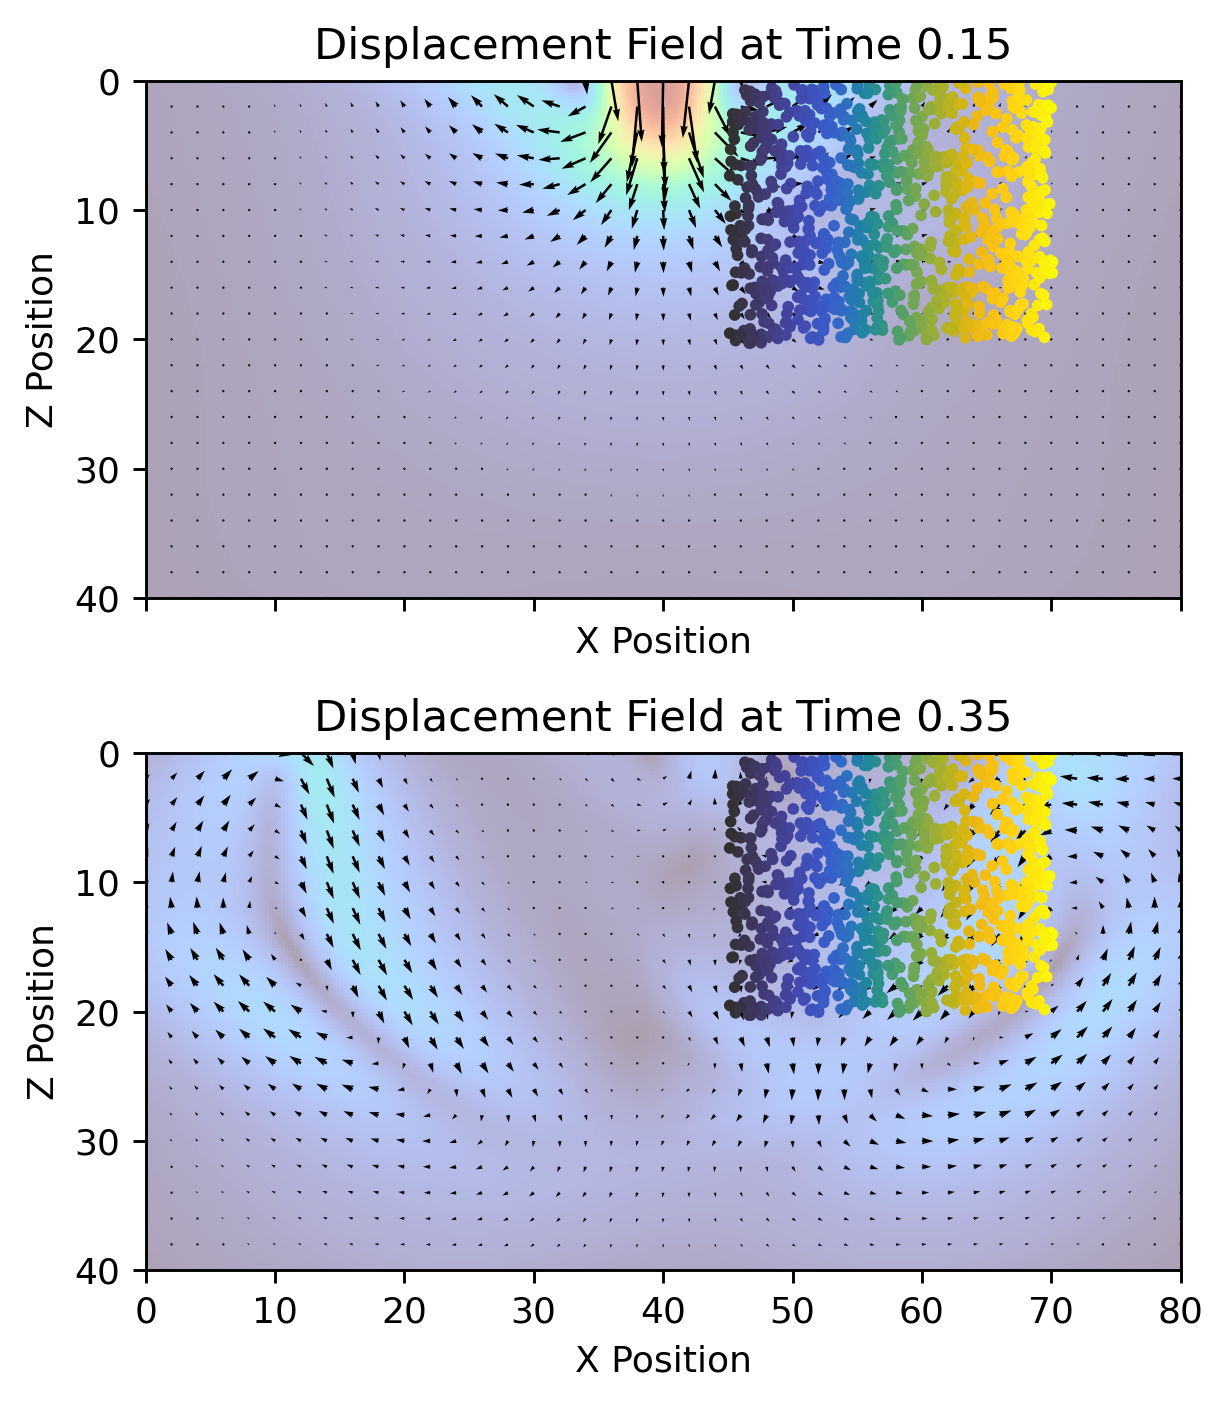

In [6]:
# Downsampling factor and meshgrid setup
factor = 8
x, z = np.meshgrid(np.linspace(0, x_model, int(x_model//dx+1)), np.linspace(0, y_model, int(y_model//dx+1)))
x_downsampled = x[::factor, ::factor]
z_downsampled = z[::factor, ::factor]

# Initialize the figure for subplots
fig, axs = plt.subplots(2, 1, figsize=(13, 5.5), sharey=True, sharex=True, dpi=260)  # 2x2 grid of plots
axs = axs.flatten()  # Flatten the array to make it easier to index

clip = 1
divnorm = colors.TwoSlopeNorm(vmin=disp_z.min()/clip, vcenter=0, vmax=disp_z.max()/clip)

# Time frames to plot
time_frames = [150, 350]  # Adjust these to the frames you want to plot

for i, frame in enumerate(time_frames):
    disp_x_slice = disp_x[frame, :, :].T / disp_z.max()
    disp_z_slice = disp_z[frame, :, :].T / disp_z.max()
    disp_x_downsampled = disp_x_slice[::factor, ::factor]
    disp_z_downsampled = disp_z_slice[::factor, ::factor]

    # Creating the quiver plot for the current frame
    axs[i].quiver(x_downsampled, z_downsampled, disp_x_downsampled, -disp_z_downsampled, scale=14)
    im = axs[i].imshow(total_disp[frame, :, :].T, extent=[0, x_model, y_model, 0], cmap='turbo', vmin=total_disp.min(), vmax=total_disp.max(), alpha=0.4)
    #im = axs[i].imshow(disp_z[frame, :, :].T, extent=[0, x_model, y_model, 0], cmap='RdBu', norm=divnorm, alpha=0.4)
    
    axs[i].scatter(scatterers[:, 0]*dx, scatterers[:, 1]*dx, c=scatterers[:, 0]*dx, cmap=cc.cm.gouldian, s=5)


    #plt.colorbar(im)
    axs[i].set_xlabel('X Position')
    axs[i].set_ylabel('Z Position')
    axs[i].set_title(f'Displacement Field at Time {frame*dtsnap:.2f}')

plt.tight_layout()

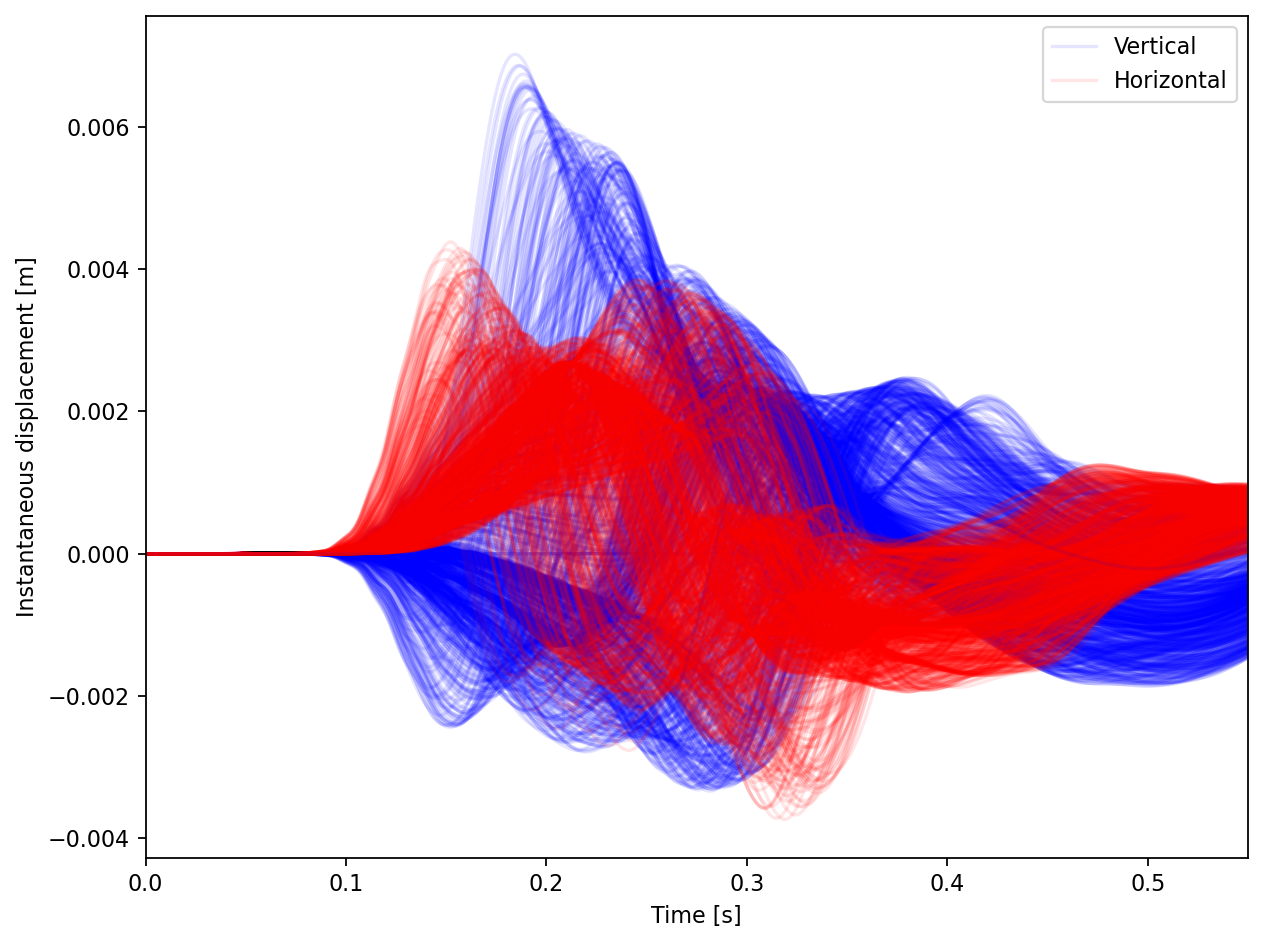

In [7]:
plt.figure(dpi=160, figsize=(8, 6))
time_axs = np.linspace(0, disp_x.shape[0]*dtsnap, disp_x.shape[0])

time_axs_inst = time_axs[1:]  

for i in range(num_scatterers-1):
    plt.plot(time_axs_inst, np.diff(np.array(list(scatterer_history.values())[i])[:, 1]*dx, axis=0), c='b', alpha=0.1)

for i in range(num_scatterers-1):
    plt.plot(time_axs_inst, np.diff(np.array(list(scatterer_history.values())[i])[:, 0]*dx, axis=0), c='r', alpha=0.1)


plt.plot(time_axs_inst, np.diff(np.array(list(scatterer_history.values())[num_scatterers-1])[:, 1]*dx, axis=0), c='b', alpha=0.1, label='Vertical')
plt.plot(time_axs_inst, np.diff(np.array(list(scatterer_history.values())[num_scatterers-1])[:, 0]*dx, axis=0), c='r', alpha=0.1, label='Horizontal')

plt.xlabel('Time [s]')
plt.ylabel('Instantaneous displacement [m]')
plt.tight_layout()
plt.xlim(0, 0.55)
plt.legend()

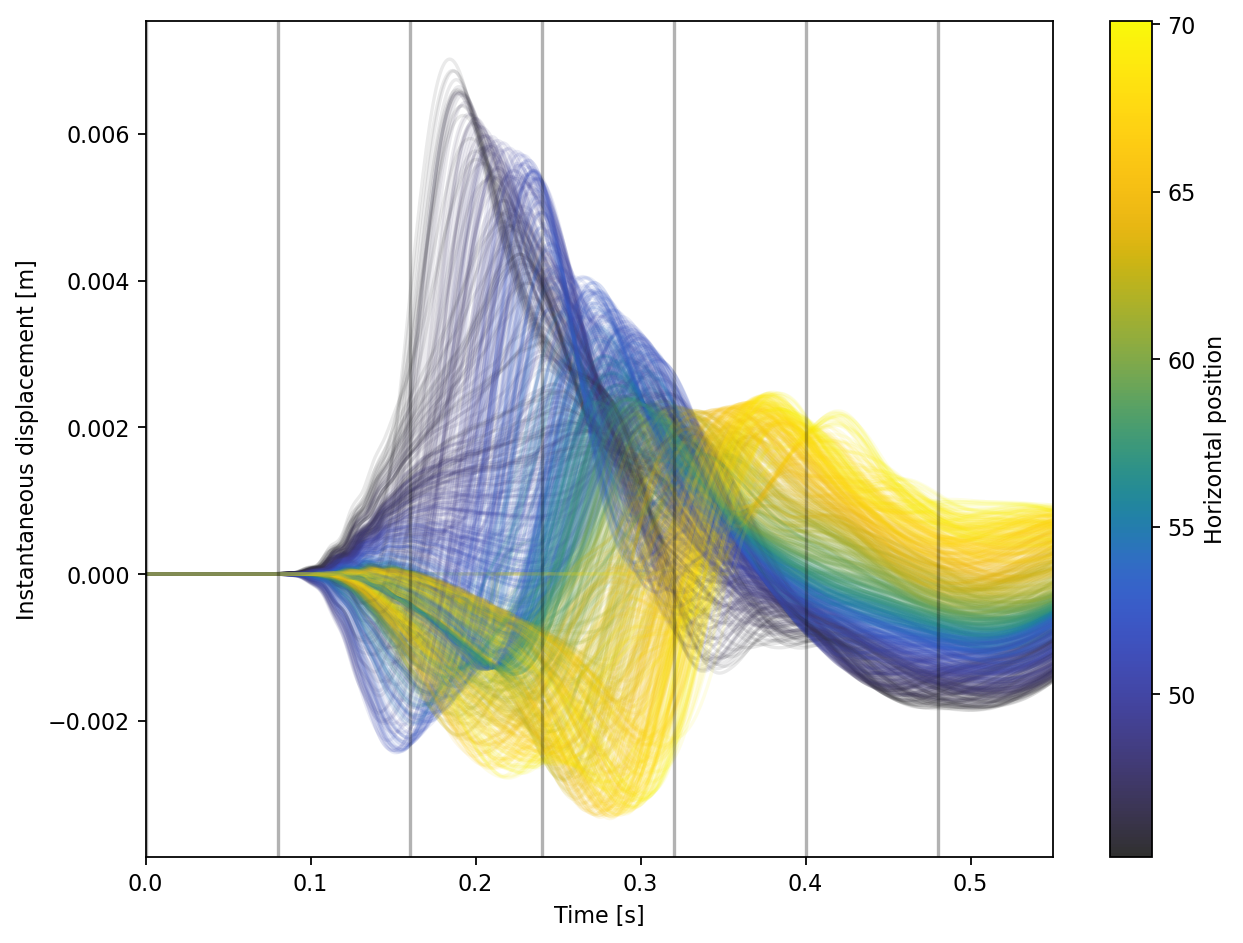

In [8]:
# Plot time vs displacement for each scatterer, color-coded by initial position
fig, ax = plt.subplots(dpi=160, figsize=(8, 6))

time_vector = np.arange(disp_x.shape[0]) * dtsnap
norm = Normalize(vmin=scatterers[:, 0].min()*dx, vmax=scatterers[:, 0].max()*dx)
cmap = plt.get_cmap(cc.cm.gouldian)

for i in range(num_scatterers):
    initial_x_position = scatterers[i, 0]*dx
    color = cmap(norm(initial_x_position))
    im = ax.plot(time_axs_inst, _arr := np.diff(np.array(list(scatterer_history.values())[i])[:, 1]*dx, axis=0), color=color, alpha=0.1)

    # max_point = np.argmax(_arr)
    # ax.scatter(time_axs_inst[max_point], _arr[max_point], c='k')

# Fix for colorbar creation
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Horizontal position')

# # Add vertical lines at specified time intervals
for t in np.arange(0, 0.55, 0.08):
    plt.axvline(t, color='black', alpha=0.3)

ax.set_xlim(0,0.55)
ax.set_xlabel('Time [s]')
plt.tight_layout()
ax.set_ylabel('Instantaneous displacement [m]')
plt.show()


In [9]:
x_pos = []
t_max = []

for i in range(num_scatterers):
    x_pos.append(scatterers[i, 0]*dx)
    t_max.append(np.argmax(np.diff(np.array(list(scatterer_history.values())[i])[:, 1]*dx, axis=0))*dtsnap)

# for i in range(num_scatterers):
#     positions = []
#     times = []
#     x_pos.append(scatterers[i, 0]*dx)

#     for ix in np.arange(80, 801-190, 80):
#         positions.append((np.array(scatterer_history[i])[ix, 1] - np.array(scatterer_history[i])[ix-80, 1])*dx)
#         times.append(ix)
    
#     t_max.append(times[np.argmax(np.array(positions))]*dtsnap)

Text(0, 0.5, 'Travel distance [m]')

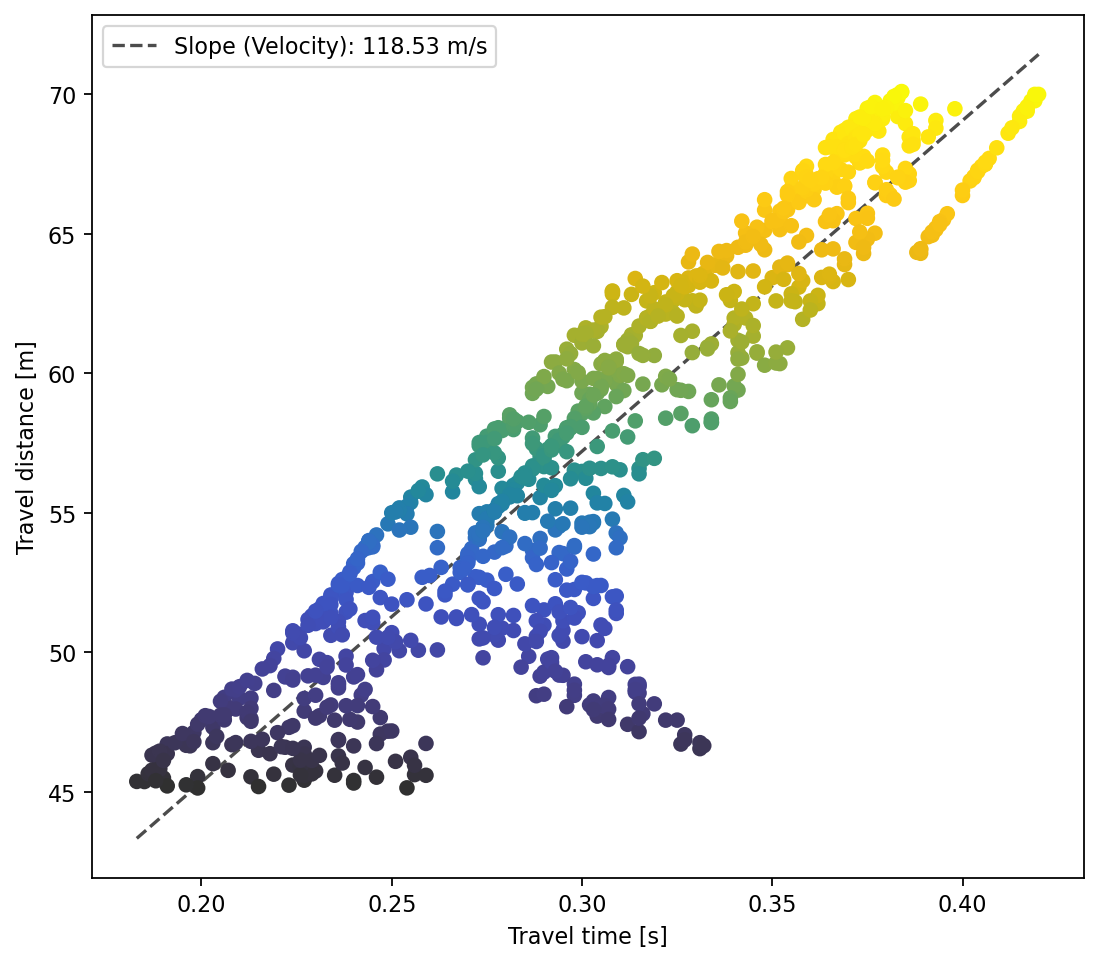

In [10]:
plt.figure(dpi=160, figsize=(8, 7))

plt.scatter(t_max, x_pos, c=x_pos, cmap=cc.cm.gouldian)

# Perform linear regression to fit a line
slope, intercept = np.polyfit(t_max, x_pos, 1)

# Now use the slope and intercept to create the line
timeaxis = np.linspace(min(t_max), max(t_max), 100)
disaxis = slope * timeaxis + intercept

plt.plot(timeaxis, disaxis, '--', alpha=0.7, c='k', zorder=0, label=f'Slope (Velocity): {slope:.2f} m/s')
plt.legend()

plt.xlabel('Travel time [s]')
plt.ylabel('Travel distance [m]')

# Simulation of experiment

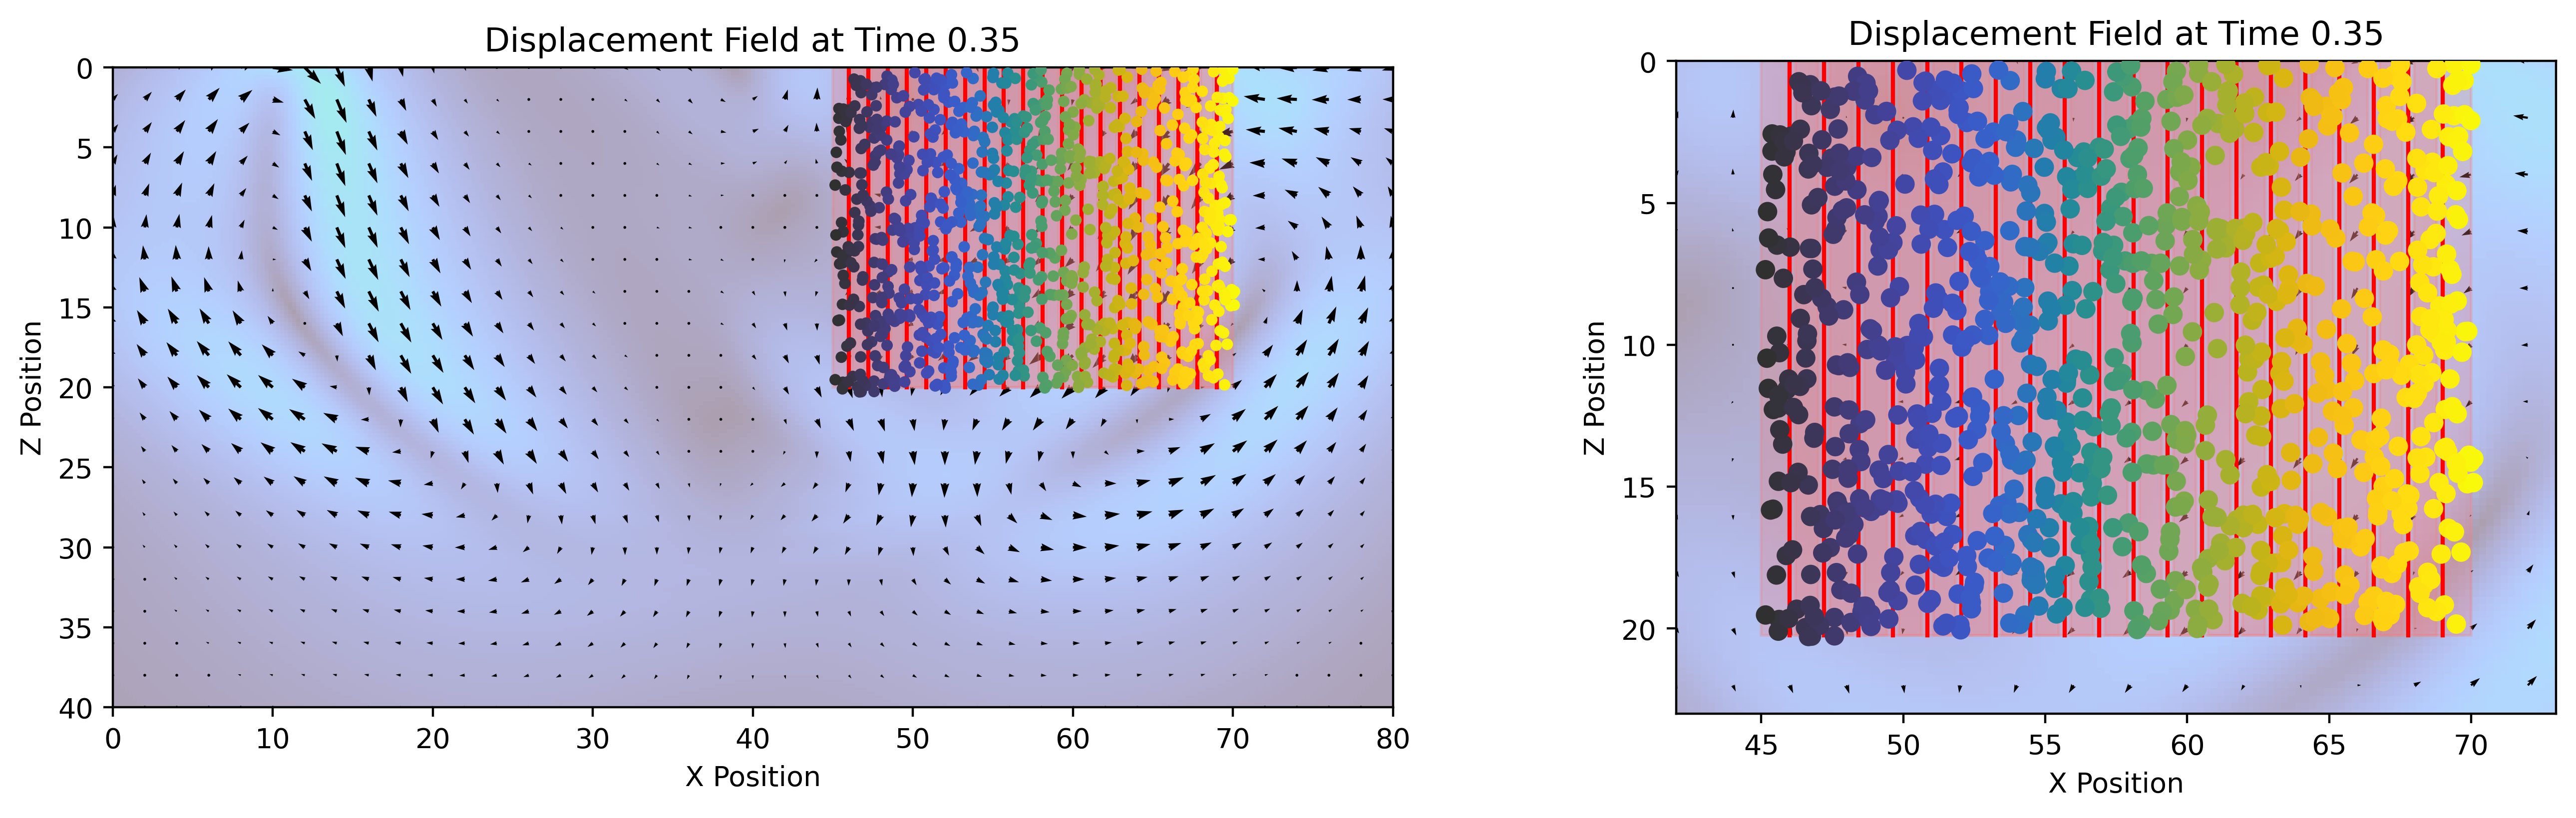

In [9]:
# Downsampling factor and meshgrid setup
factor = 8
x, z = np.meshgrid(np.linspace(0, x_model, int(x_model//dx+1)), np.linspace(0, y_model, int(y_model//dx+1)))
x_downsampled = x[::factor, ::factor]
z_downsampled = z[::factor, ::factor]
frame=350

# Sensors location 
num_receivers = 20
beamwidth = 2
receiver_positions = np.linspace(window[0]*dx + beamwidth/2, window[1]*dx - beamwidth/2, num_receivers)

# Initialize the figure for subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 4.2), dpi=400)  # 2x2 grid of plots
axs = axs.flatten()  # Flatten the array to make it easier to index

disp_x_slice = disp_x[frame, :, :].T / disp_z.max()
disp_z_slice = disp_z[frame, :, :].T / disp_z.max()
disp_x_downsampled = disp_x_slice[::factor, ::factor]
disp_z_downsampled = disp_z_slice[::factor, ::factor]

# Creating the quiver plot for the current frame
axs[0].quiver(x_downsampled, z_downsampled, disp_x_downsampled, -disp_z_downsampled, scale=14)
im = axs[0].imshow(total_disp[frame, :, :].T, extent=[0, x_model, y_model, 0], cmap='turbo', vmin=total_disp.min(), vmax=total_disp.max(), alpha=0.4, aspect='equal')
axs[0].scatter(scatterers[:, 0]*dx, scatterers[:, 1]*dx, c=scatterers[:, 0]*dx, cmap=cc.cm.gouldian, s=10, zorder=15)

# Creating the quiver plot for the current frame
axs[1].quiver(x_downsampled, z_downsampled, disp_x_downsampled, -disp_z_downsampled, scale=14)
im = axs[1].imshow(total_disp[frame, :, :].T, extent=[0, x_model, y_model, 0], cmap='turbo', vmin=total_disp.min(), vmax=total_disp.max(), alpha=0.4, aspect='equal')
axs[1].scatter(scatterers[:, 0]*dx, scatterers[:, 1]*dx, c=scatterers[:, 0]*dx, cmap=cc.cm.gouldian, zorder=15)

for pos in receiver_positions:
    axs[0].axvline(pos, ymin=0.5, ymax=1, color='red')
    axs[0].axvspan(pos-1, pos+1, ymin=0.5, ymax=1, color='lightcoral', alpha=0.3)

for pos in receiver_positions:
    axs[1].axvline(pos, ymin=0.12, ymax=1, color='red')
    axs[1].axvspan(pos-1, pos+1, ymin=0.12, ymax=1, color='lightcoral', alpha=0.3)

axs[1].set_xlabel('X Position')
axs[1].set_ylabel('Z Position')
axs[1].set(xlim=(window[0]*dx-3, window[1]*dx+3), ylim=(window[2]*dx+3, 0))
axs[1].set_title(f'Displacement Field at Time {frame*dtsnap:.2f}')

axs[0].set_xlabel('X Position')
axs[0].set_ylabel('Z Position')
axs[0].set_title(f'Displacement Field at Time {frame*dtsnap:.2f}')

plt.tight_layout()

In [16]:
# List of variable names you want to save
variables_to_save = ['x_model', 'y_model', 'dx', 'dtsnap', 'factor', 'disp_x', 'disp_z', 'total_disp', 'scatterers', 'window', 'num_receivers', 'beamwidth', 'receiver_positions']

# Dictionary to hold your variables
data_to_save = {}

for var in variables_to_save:
    data_to_save[var] = globals()[var]

# Save the dictionary into a pickle file
with open('/home/riascodc/Documents/ARF/Images/img_npy/scatterers.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [466]:
central_frequency = 12000  # Hz
sampling_rate = 20000  # Hz
duration = 0.09  # Seconds
points = int(duration * sampling_rate)
speed_of_sound = 1500  # m/s
np.random.seed(0)

# Assuming other parameters (central_frequency, sampling_rate, etc.) are defined as before
num_time_steps = len(scatterer_history[0])  # Assuming this is defined as before

# Generate Ricker wavelet
wavelet = ricker(points, (central_frequency / sampling_rate) * np.pi * 2)

def simulate_signals(scatterer_history, receiver_positions, beamwidth, dx, num_receivers, num_time_steps, scatterer_amplitudes):
    signals_time_steps = np.zeros((num_receivers, num_time_steps, points))

    for frame in range(num_time_steps):
        for i, pos in enumerate(receiver_positions):
            signals_frame = np.zeros(points)
            
            # Retrieve scatterers' positions for this frame
            scatterers_frame = np.array([scatterer_history[sc][frame] for sc in range(num_scatterers)])
            
            # Filter scatterers within the beamwidth of the current receiver and use fixed amplitudes
            for scatterer_index, scatterer in enumerate(scatterers_frame):
                if pos - beamwidth/2 <= scatterer[0]*dx <= pos + beamwidth/2:
                    depth = scatterer[1] * dx
                    spike_time = int(((2 * (depth+40)) / speed_of_sound) * sampling_rate)
                    if spike_time < points:
                        signals_frame[spike_time] += scatterer_amplitudes[scatterer_index]  # Use fixed amplitude

            # Convolve signal with Ricker wavelet
            signals_time_steps[i, frame, :] = convolve(signals_frame, wavelet, mode='same')

    return signals_time_steps

# Simulate and plot signals with fixed amplitudes
sigs = simulate_signals(scatterer_history, receiver_positions, beamwidth, dx, num_receivers, num_time_steps, scatterer_amplitudes)

/tmp/ipykernel_96055/1156113470.py:12: DeprecationWarning: scipy.signal.ricker is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  wavelet = ricker(points, (central_frequency / sampling_rate) * np.pi * 2)


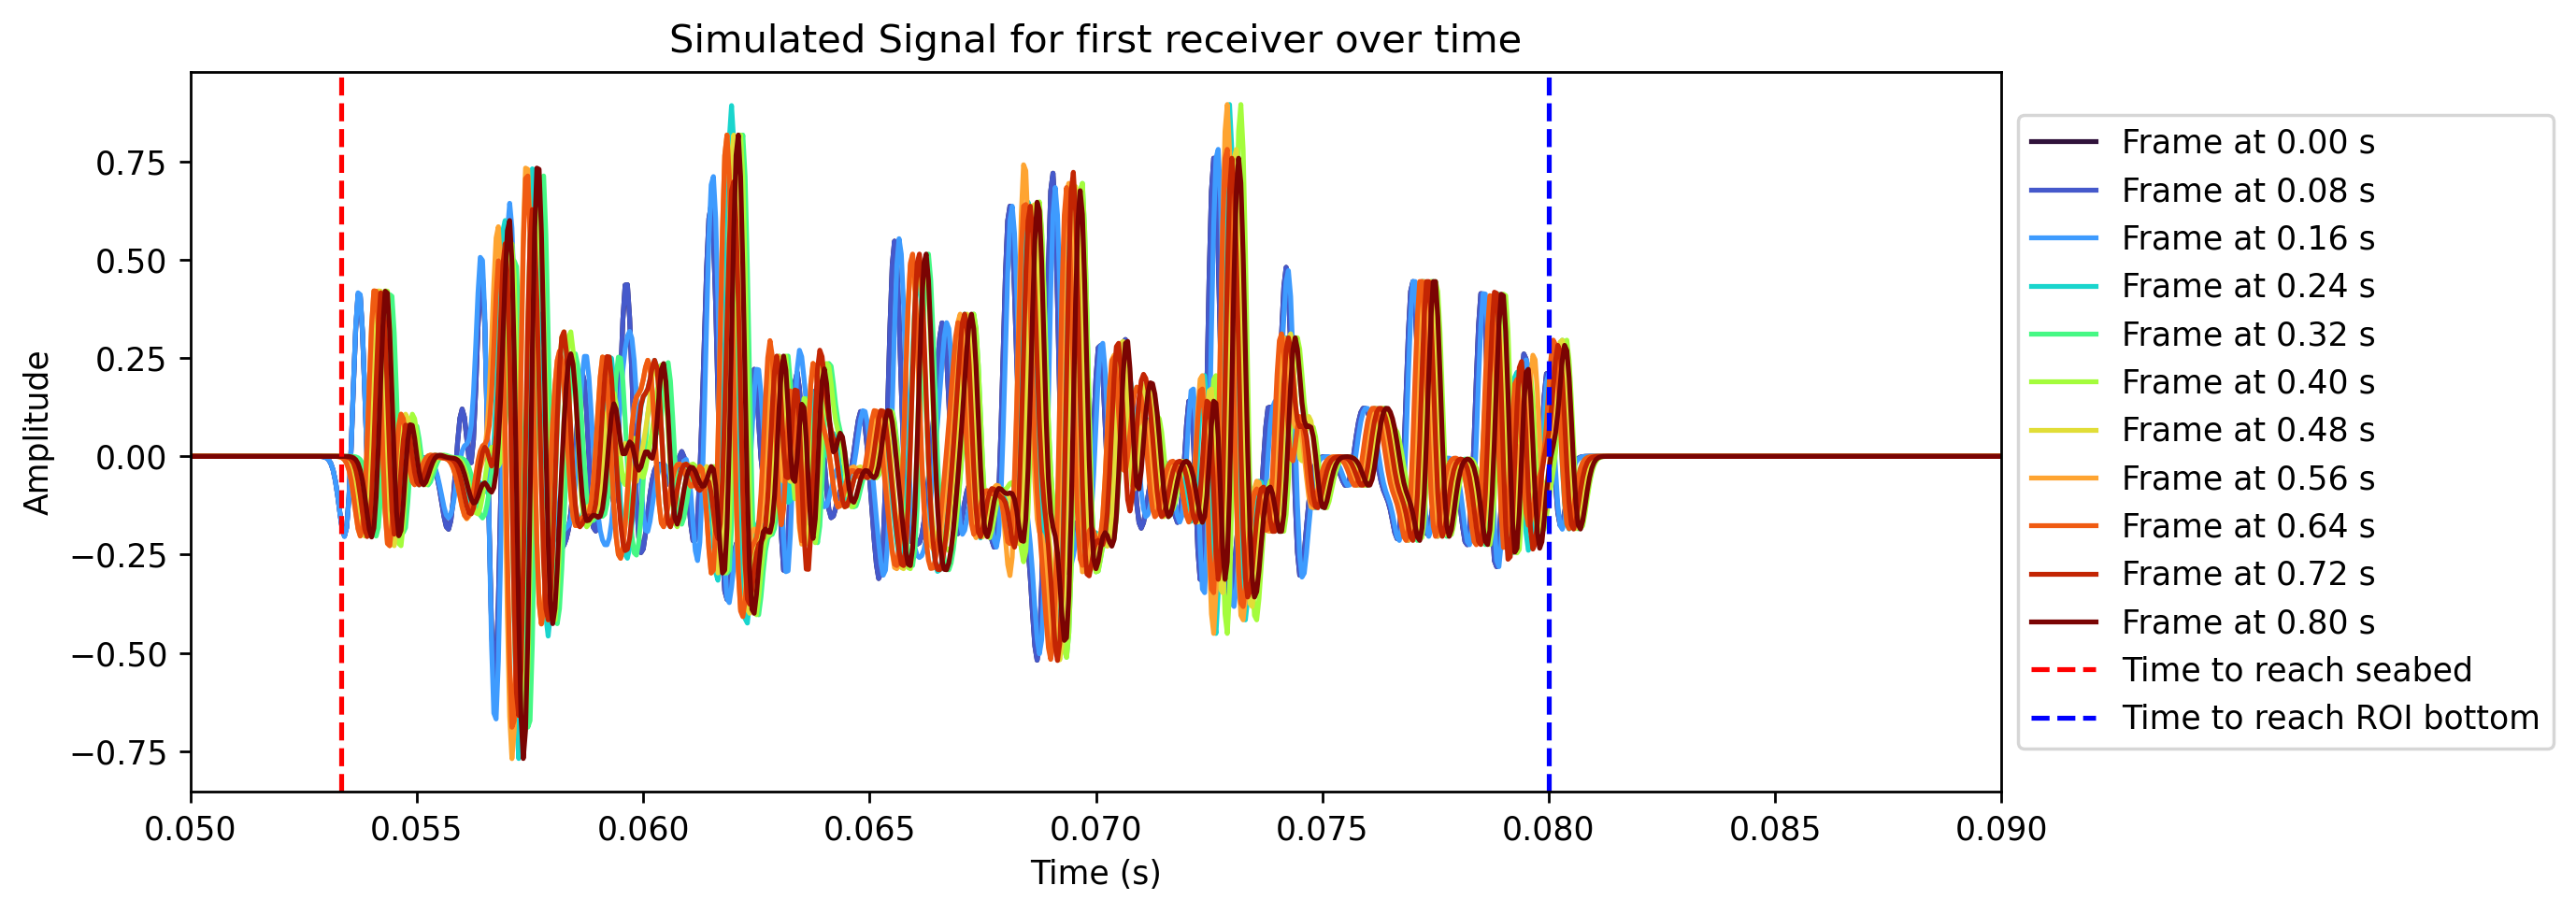

In [81]:
from matplotlib import cm

# Plotting the signals for the first receiver as an example
fig, ax = plt.subplots(figsize=(10, 4), dpi=250)
time = np.arange(points) / sampling_rate
colors = cm.turbo(np.linspace(0, 1, num_time_steps))

for frame in range(0, num_time_steps, 80):
    ax.plot(time, sigs[0, frame, :], color=colors[frame], label=f'Frame at {frame*dtsnap:.2f} s' if frame % (num_time_steps // 80) == 0 else "")
    #ax.plot(time, signals_time_steps_one[frame, :], color=colors[frame], label=f'Frame at {frame*dtsnap:.2f} s' if frame % (num_time_steps // 80) == 0 else "")

ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Simulated Signal for first receiver over time')
plt.xlim(0.05, duration)
plt.axvline(80/speed_of_sound, label='Time to reach seabed', color='red', ls='--')
plt.axvline(120/speed_of_sound, label='Time to reach ROI bottom', color='blue', ls='--')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [82]:
signal1 = sigs[0, 100, :]
signal2 = sigs[0, 200, :]

wl = 0.003  # seconds

def windowed_cross_correlation(signal1, signal2, window_length, sampling_rate = sampling_rate, speed_of_sound = speed_of_sound):

    srl = wl * 2  # seconds

    window_samples = int(wl * sampling_rate)
    search_region_samples = int(srl * sampling_rate)

    displacements = []
    times = []

    for i in range(window_samples // 2, len(signal2) - window_samples // 2, window_samples // 4):
        times.append(i)

        window = signal2[i - window_samples // 2: i + window_samples // 2]
        search_region = signal1[max(i - search_region_samples // 2, 0): i + search_region_samples // 2]

        if np.all(window == 0) or np.all(search_region == 0):
            displacements.append(0)
        
        else:
            correlation = correlate(search_region, window, mode='full')

            if correlation.max() > 1e-1:
                sorted_idx = np.argsort(correlation)
                top3 = sorted_idx[-5:]

                if np.abs(top3[-1] - ((len(search_region) + len(window)) // 2 - 1)) <= 10:
                    peak_index = top3[-1]
                
                elif np.abs(top3[-2] - ((len(search_region) + len(window)) // 2 - 1)) <= 10:
                    peak_index = top3[-2]

                else:
                    displacements.append(np.nan)
                    continue

                num_points = 3  # Points on each side of the peak for fitting
                fit_indices = np.arange(max(0, peak_index - num_points), min(peak_index + num_points + 1, len(correlation)))
                fit_values = correlation[fit_indices]

                fit_coeffs = np.polyfit(fit_indices, fit_values, 2)
                vertex_index = -fit_coeffs[1] / (2 * fit_coeffs[0])

                shift_samples = vertex_index - ((len(search_region) + len(window)) // 2 - 1)
                refined_dt = shift_samples / sampling_rate
                displacement = (shift_samples / sampling_rate) * speed_of_sound / 2

                displacements.append(displacement)

                if np.abs(shift_samples) > 30:

                    print(top3, np.argmax(correlation))

                    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

                    axs[0].plot(np.linspace(i - window_samples // 2, i + window_samples // 2, len(window)), window, label='Window')
                    axs[0].plot(np.linspace(i - search_region_samples // 2, i + search_region_samples // 2, len(search_region)), search_region, label='Search Region')
                    axs[0].legend()

                    axs[1].plot(correlation, 'k--', marker='o', label='Correlation')
                    axs[1].axvline(peak_index, color='blue', label='Peak Index')
                    axs[1].set_xlim(peak_index - 10*num_points, peak_index + 10*num_points)
                    axs[1].scatter(fit_indices, fit_values, color='red', zorder=5, label='Fit Points')

                    # Plotting the fitted parabola
                    dense_fit_indices = np.linspace(fit_indices[0], fit_indices[-1], num=100)
                    parabola_values = np.polyval(fit_coeffs, dense_fit_indices)
                    axs[1].plot(dense_fit_indices, parabola_values, 'g-', label='Fitted Parabola')
                    axs[1].legend()

                    axs[2].plot(np.linspace(i - window_samples//2, i+window_samples//2, len(window))+shift_samples, window)
                    axs[2].plot(np.linspace(i - search_region_samples//2, i+search_region_samples//2, len(search_region)), search_region)

                    plt.show()

            else:
                displacements.append(np.nan)

    # Convert the list to a NumPy array if it isn't one already
    displacements_array = np.array(displacements)
    non_nan_indices = np.where(~np.isnan(displacements_array))[0]
    nan_indices = np.where(np.isnan(displacements_array))[0]
    displacements_array[nan_indices] = np.interp(nan_indices, non_nan_indices, displacements_array[non_nan_indices])

    return times, displacements_array

times, displacements_array = windowed_cross_correlation(signal1, signal2, wl)

(40.0, 60.0)

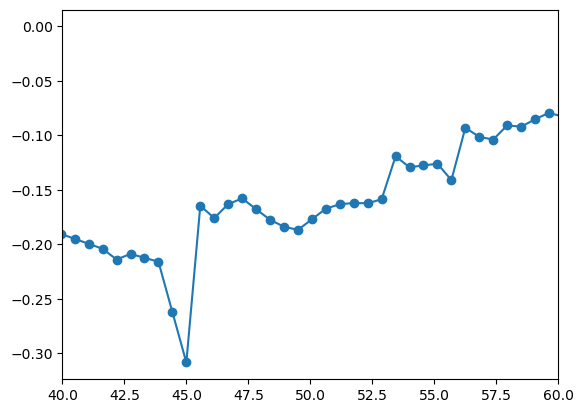

In [83]:
plt.plot((np.array(times)/sampling_rate)*(speed_of_sound/2), displacements_array, marker='o')
plt.xlim(40, 60)

In [467]:
def estimate_displacements_for_all_receivers(sigs, interval, wl = 0.003, dt = dtsnap):
    """
    Estimates displacements for all receivers and returns a matrix with dimensions [time, x, y].
    :param sigs: Signal array with dimensions [receiver, time, sample].
    :param time_step1: The first time step to compare.
    :param time_step2: The second time step to compare.
    :return: 3D matrix of displacements with dimensions [time, x, y].
    """
    num_receivers = sigs.shape[0]

    matrix_time = []
    times = np.arange(0, 500, interval)

    for t in times:
    
        displacements_list = []

        for receiver_index in range(num_receivers):
            signal1 = sigs[receiver_index, t, :]
            signal2 = sigs[receiver_index, t + interval, :]
            _t, displacements = windowed_cross_correlation(signal1, signal2,wl)
            displacements_list.append(displacements) 

        matrix_time.append(np.vstack(displacements_list))

    return times*dt, np.array(matrix_time)


In [468]:
timess, matrix_time = estimate_displacements_for_all_receivers(sigs, 20, wl)
matrix_time = matrix_time[:, :, 69: 105]

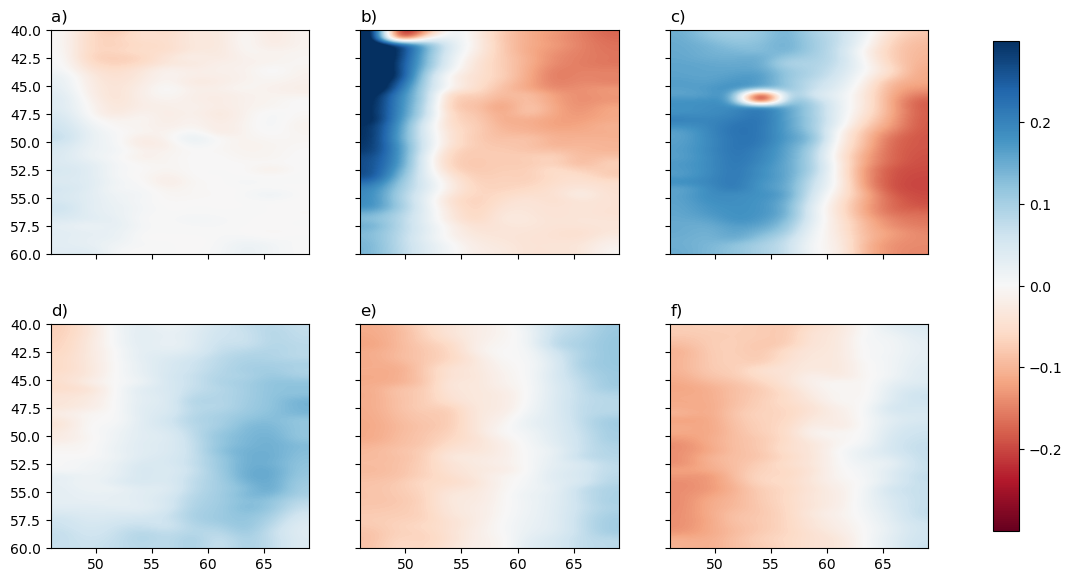

In [17]:
from matplotlib import colors

# Initialize the figure for subplots
clip = 1
divnorm = colors.TwoSlopeNorm(vmin=-0.3/clip, vcenter=0, vmax=0.3/clip)

fig, axs = plt.subplots(2, 3, figsize=(13, 7), sharey=True, sharex=True)  # 2x2 grid of plots
axs = axs.flatten()  # Flatten the array to make it easier to index
titles = ['a', 'b', 'c', 'd', 'e', 'f']

for t, tit in zip(range(1, matrix_time.shape[0], 1), titles):
    im = axs[t-1].imshow(-matrix_time[t].T, extent=[receiver_positions.min(), receiver_positions.max(), 60, 40], norm=divnorm, interpolation='bicubic', cmap='RdBu', aspect='equal')
    #axs[t-1].set_ylim(60, 40)
    axs[t-1].set_title(f'{tit})', loc='left')

# Create a colorbar with specific location and size
fig.subplots_adjust(right=0.8)  # Make room for the colorbar on the right
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])  # Adjust these values as needed
fig.colorbar(im, cax=cbar_ax)


plt.show()

In [85]:
# Bundle your variables into a dictionary
data_to_save = {
    "clip": clip,
    "matrix_time": matrix_time,
    "receiver_positions": receiver_positions,
    "times": timess
}

# Save the dictionary into a pickle file
with open("/home/riascodc/Documents/ARF/Images/img_npy/est-disp-ball.pkl", "wb") as file:
    pickle.dump(data_to_save, file)

In [82]:
x = timess
xs = np.linspace(0, timess[-1], 500)

vels = []

for depth in range(0, matrix_time.shape[2], 3): 

    x_pos = []
    t_max = []
    for i in range(num_receivers):
        x_pos.append(receiver_positions[i])

        displacements = matrix_time[:, i, depth]
        cs = CubicSpline(x, displacements, bc_type='natural')

        t_max.append(xs[np.argmax(-cs(xs, 0))])

    # Perform linear regression to fit a line
    slope, intercept = np.polyfit(t_max, x_pos, 1)
    vels.append(slope)

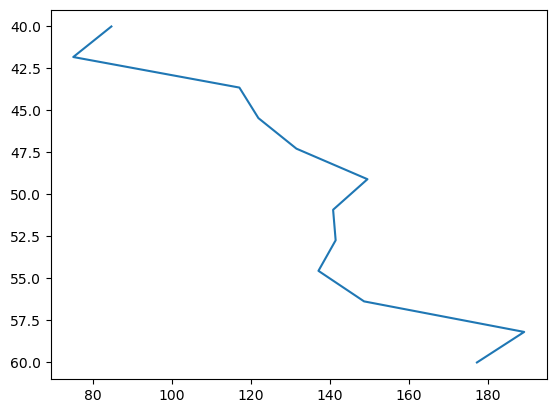

In [83]:
depths = np.linspace(40, 60, len(vels))
plt.plot(vels, depths)
plt.gca().invert_yaxis()

Text(0, 0.5, 'Travel distance [m]')

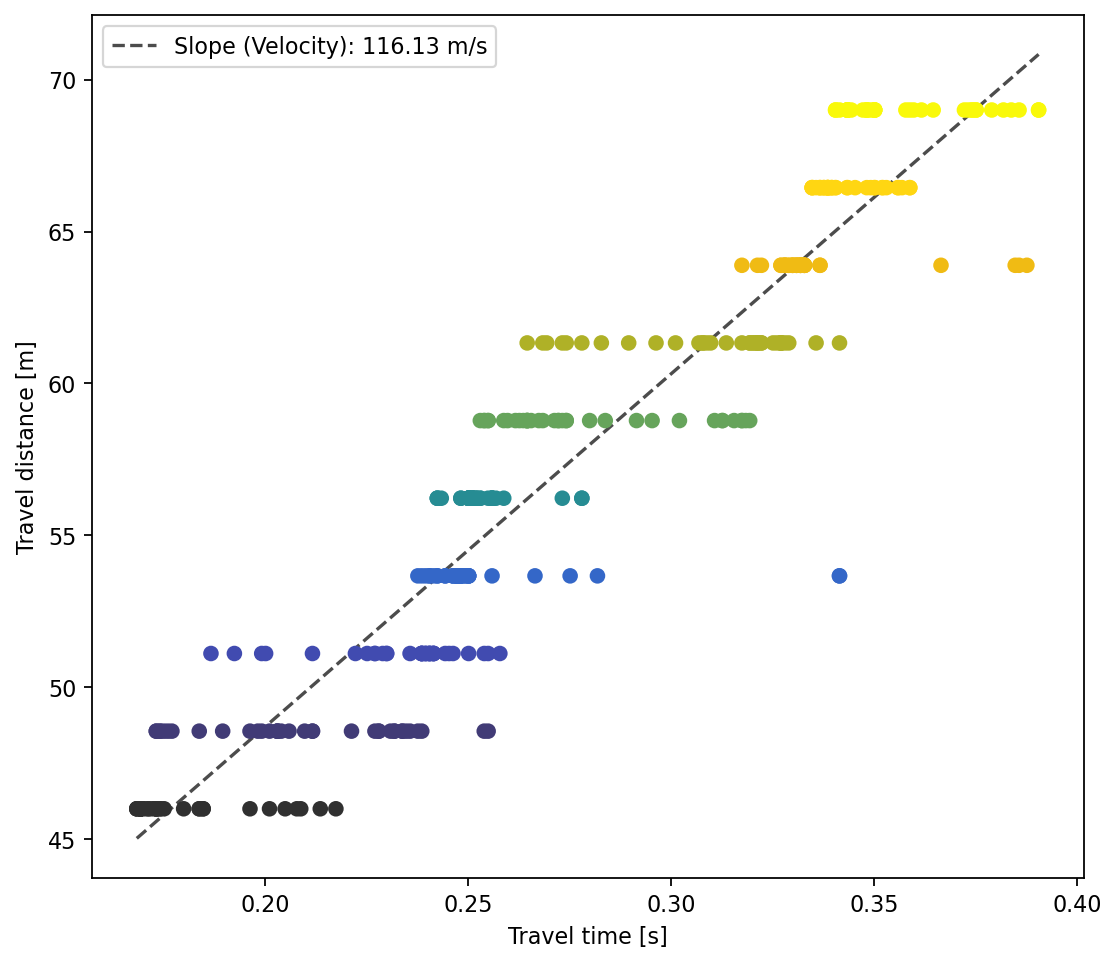

In [56]:
plt.figure(dpi=160, figsize=(8, 7))

plt.scatter(t_max, x_pos, c=x_pos, cmap=cc.cm.gouldian)

# Perform linear regression to fit a line
slope, intercept = np.polyfit(t_max, x_pos, 1)

# Now use the slope and intercept to create the line
timeaxis = np.linspace(min(t_max), max(t_max), 100)
disaxis = slope * timeaxis + intercept

plt.plot(timeaxis, disaxis, '--', alpha=0.7, c='k', zorder=0, label=f'Slope (Velocity): {slope:.2f} m/s')
plt.legend()

plt.xlabel('Travel time [s]')
plt.ylabel('Travel distance [m]')

In [461]:
cumsum_in_windows(disp_z[:500, range(int(45/dx), int(70/dx), 1), :int(20/dx)], 20).shape, matrix_time.shape

((25, 100, 80), (25, 10, 36))

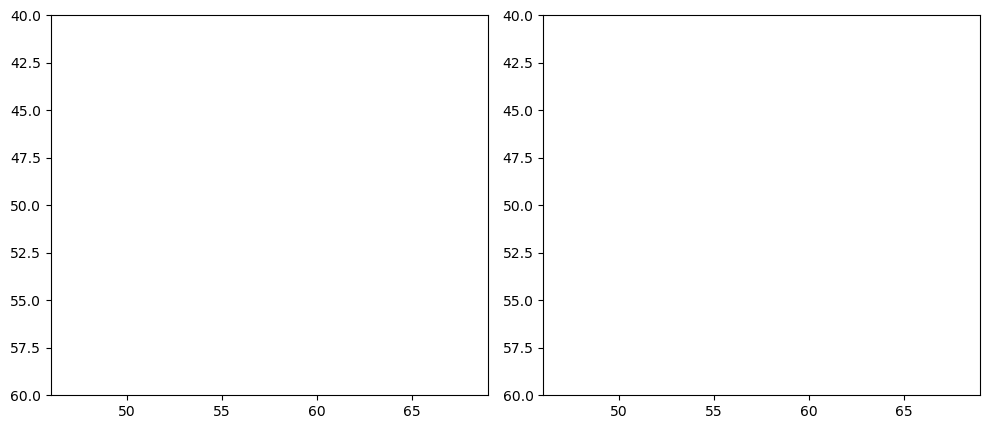

In [469]:
from matplotlib import colors

clip = 3
divnorm = colors.TwoSlopeNorm(vmin=-0.2/clip, vcenter=0, vmax=0.2/clip)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
camera = Camera(fig)

for t in range(matrix_time.shape[0]):
    axs[0].imshow(-cumsum_in_windows(disp_z[:500, range(int(45/dx), int(70/dx), 1), :int(20/dx)], 20)[t, :, :].T, extent=[receiver_positions.min(), receiver_positions.max(), 60, 40], norm=divnorm, interpolation='none', cmap='RdBu_r', aspect='equal')
    axs[1].imshow(matrix_time[t, :, :].T, extent=[receiver_positions.min(), receiver_positions.max(), 60, 40], norm=divnorm, interpolation='none', cmap='RdBu_r', aspect='equal')
    plt.tight_layout()

    camera.snap()

animation = camera.animate(interval = 200)
animation.save('video.mp4')

In [556]:
def Invert4Mu(matrix_time):

    # First derivatives
    first_derivatives_time = np.gradient(matrix_time, axis=0)
    first_derivatives_x = np.gradient(matrix_time, axis=1)
    first_derivatives_z = np.gradient(matrix_time, axis=2)

    # Second derivatives
    second_derivatives_time = np.gradient(first_derivatives_time, axis=0)
    second_derivatives_x = np.gradient(first_derivatives_x, axis=1)
    second_derivatives_z = np.gradient(first_derivatives_z, axis=2)

    # Fourier transform for the Laplacian in spatial domain (x and z)
    laplacian = second_derivatives_x + second_derivatives_z
    # Avoid division by zero
    laplacian[laplacian == 0] = np.inf

    mu_xz = 1/matrix_time.shape[0] * np.nansum(second_derivatives_time / laplacian, axis=0)

    return mu_xz, second_derivatives_time, laplacian

def cumsum_in_windows(matrix, n):
    """
    Performs a cumulative sum over windows of length n in the time dimension, creating an undersampled matrix.
    
    Parameters:
    - matrix: np.array, the original matrix with dimensions [time, x, z].
    - n: int, the window length for the cumulative sum.
    
    Returns:
    - undersampled_matrix: np.array, an undersampled matrix with each element being the sum over a window of size n,
                           with dimensions [time_undersampled, x, z].
    """
    # Initialize an empty list to hold the cumsum results for each window
    window_cumsums = []
    
    # Iterate over the matrix in windows of size n
    for i in range(0, matrix.shape[0], n):
        # Ensure we don't go out of bounds in the final window
        end_index = i + n if (i + n) <= matrix.shape[0] else matrix.shape[0]
        
        # Calculate the cumsum for the current window and sum it
        window_sum = np.sum(matrix[i:end_index, :, :], axis=0)
        
        # Append the sum of the current window to the list
        window_cumsums.append(window_sum)
    
    # Convert the list of window sums to a NumPy array to form the undersampled matrix
    undersampled_matrix = np.array(window_cumsums)
    
    return undersampled_matrix

#mu_xz = Invert4Mu(cumsum_in_windows(disp_z[250:, int(45/dx):int(70/dx), :int(20/dx)], 20))
#mu_xz, sd_time, sd_space = Invert4Mu(disp_z[200:, int(45/dx):int(70/dx), :int(20/dx)])
mu_xz, sd_time, sd_space = Invert4Mu(cumsum_in_windows(disp_z[200:, int(45/dx):int(70/dx):1, :int(20/dx):1], 20))
#mu_xz = Invert4Mu(matrix_time[:, :, :])


In [557]:
int(45/dx), int(70/dx)

(180, 280)

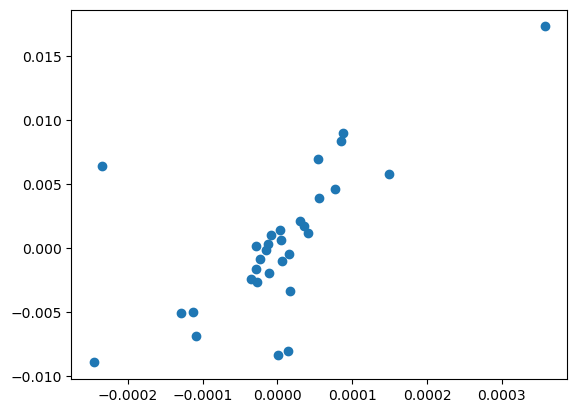

In [558]:
plt.scatter(sd_space[:, 7, 7], sd_time[:, 7, 7])

In [526]:
mu_xz.shape, matrix_time.shape[1:]

((34, 27), (20, 36))

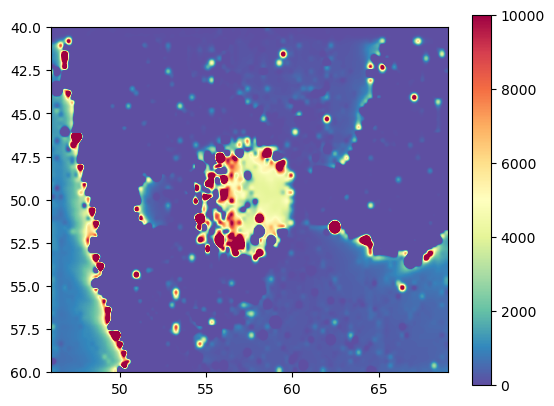

In [559]:
plt.imshow(mu_xz.T, cmap='Spectral_r', interpolation='gaussian', vmin=0, vmax=1e4, extent=[receiver_positions.min(), receiver_positions.max(), 60, 40])
plt.colorbar()

In [373]:
matrix_time.shape

(25, 10, 36)

(-0.08, 0.08)

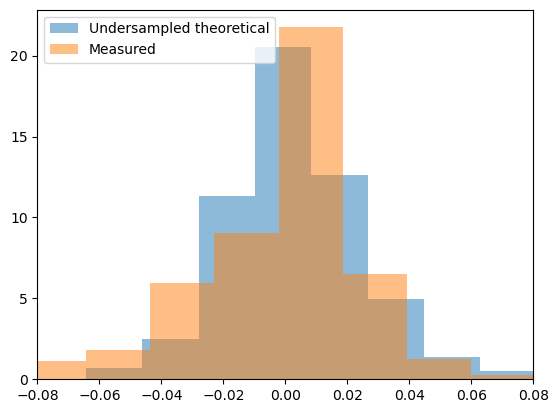

In [358]:
plt.hist(cumsum_in_windows(disp_z[200:, int(45/dx):int(70/dx), :int(20/dx)], 20).flatten(), density=True, alpha=0.5, label='Undersampled theoretical')
plt.hist(matrix_time.flatten(), density=True, alpha=0.5, label='Measured')

plt.legend()
plt.xlim(-0.08, 0.08)

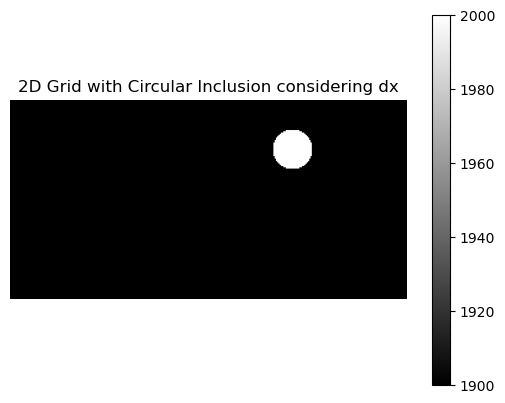

In [118]:
# Adjusting dimensions and circle properties based on dx
# Assuming the physical dimensions given now need to be adjusted by dx
# Thus, the actual grid size in terms of dx units
x_model_dx = int(x_model / dx+1)
y_model_dx = int(y_model / dx+1)

new_circle_center = (57, 10)
new_circle_radius = 4

# Adjusting circle center and radius based on dx
circle_center_dx = (int(new_circle_center[0] / dx), int(new_circle_center[1] / dx))
circle_radius_dx = int(new_circle_radius / dx)

# Create a new grid with dx adjustments
dx_grid = np.ones((y_model_dx, x_model_dx))*1900

# Add a circular inclusion with adjusted properties
for y in range(y_model_dx):
    for x in range(x_model_dx):
        if (x - circle_center_dx[0])**2 + (y - circle_center_dx[1])**2 < circle_radius_dx**2:
            dx_grid[y, x] = 2000

# Plotting the new grid with dx considered
plt.imshow(dx_grid, cmap='gray')
plt.colorbar()
plt.title('2D Grid with Circular Inclusion considering dx')
plt.axis('off')
plt.show()
